In [1]:
from __future__ import division

In [2]:
import math
import random
import numpy as np
import pandas as pd

In [3]:
from sklearn import datasets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 1

%aimport gtree

In [6]:
import logging
%config Application.log_level="INFO"
logging.basicConfig(format='%(asctime)s %(name)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

## Goals:

### Separate the structure of a tree from the data of a tree.  In other words,
  fitting a tree does two things: It creates the structure of a tree and it
  creates a mapping of each leaf to a value.  Lookup therefore requires both
  finding the leaf node AND using the map to lookup the value.
  
### The loss function optimized by the tree is configurable, as is the leaf


## Terms:

### Tree
A Tree is an object that takes input data and determines what leaf it ends up in.  Unlike many tree implementations, the Tree itself doesn't store data about the value of a leaf.  That is stored externally.


### loss_fn
A loss_fn is a function that takes data rows, the predicted targets for those rows, and the actual targets for those rows, and returns a single value that determines the "LOSS" or "COST" of that prediction (lower cost/loss is better)

```
def loss_fn(predicted_targets, actual_targets) -> float
```

A loss function must be additive (so, one should not apply a mean as a part of it)

### leaf_prediction_fn
A leaf_prediction_fn is a function which takes the features and actual targets that end up in a leaf and returns a Series of the predictions for each row ending up in that leaf.  It is typically a constant function whose value is either the mean good rate in that leaf (among the actual targets) or the median target, but can be anything else

```
def leaf_prediction_fn(features) -> pd.Series
```


### leaf_prediction_builder
A leaf_prediction_builder is a function which takes the features and actual targets that end up in a TRANING leaf and returns a leaf_prediction_fn.  This leaf_prediction_fn is used to predict the value of testing rows that end up in the same leaf.

```
def leaf_prediction_builder(features, actual_targets) -> leaf_prediction_fn
```


### leaf_prediction_map
A leaf_prediction_map is a map of leaf ids (eg their hash) to the leaf_prediction_fn for that leaf.  One can only use a tree to score data if one has a leaf_prediction_map.  This design allows on to use the same tree as a subset of another tree without having their leaf values become entangled.

--------------

## Test Tree Manipulation Functions

In [129]:
%pdb off

Automatic pdb calling has been turned OFF


In [130]:
t = gtree.BranchNode('A', 0.5, None, None)
t.left = gtree.LeafNode()
t.right = gtree.BranchNode('B', 0.9, None, None)
t.right.left = gtree.LeafNode()
t.right.right = gtree.LeafNode()

o = gtree.BranchNode('C', 0.1, None, None)
o.left = gtree.LeafNode()
o.right = gtree.LeafNode()

t.prn()
print '\n\n'
o.prn()

	Leaf(0.428436903385)

A 0.5

		Leaf(0.0338379649993)

	B 0.9

		Leaf(0.221294322098)




	Leaf(0.82595098352)

C 0.1

	Leaf(0.729526839382)



In [131]:
u = gtree.replace_branch_split(t, t.right, o)
u.prn()
print '\n\n'
t.prn()

	Leaf(0.428436903385)

A 0.5

		Leaf(0.0338379649993)

	C 0.1

		Leaf(0.221294322098)




	Leaf(0.428436903385)

A 0.5

		Leaf(0.0338379649993)

	B 0.9

		Leaf(0.221294322098)



In [135]:
v = gtree.replace_node(t, t.left, o)
v.prn()
print '\n\n'
t.prn()

		Leaf(0.82595098352)

	C 0.1

		Leaf(0.729526839382)

A 0.5

		Leaf(0.0963718392277)

	B 0.9

			Leaf(0.675293137228)

		C 0.9

			Leaf(0.622575315591)




	Leaf(0.667447300598)

A 0.5

		Leaf(0.0963718392277)

	B 0.9

			Leaf(0.675293137228)

		C 0.9

			Leaf(0.622575315591)



In [133]:
t = gtree.BranchNode('A', 0.5, None, None)
t.left = gtree.LeafNode()
t.right = gtree.BranchNode('B', 0.9, None, None)
t.right.left = gtree.LeafNode()
t.right.right = gtree.BranchNode('C', 0.9, None, None)
t.right.right.right = gtree.LeafNode()
t.right.right.left = gtree.LeafNode()

t.prn()
print '\n\n'
gtree.prune(t, 2).prn()
print '\n\n'
t.prn()

	Leaf(0.667447300598)

A 0.5

		Leaf(0.0963718392277)

	B 0.9

			Leaf(0.675293137228)

		C 0.9

			Leaf(0.622575315591)




	Leaf(0.667447300598)

A 0.5

		Leaf(0.859152924788)

	B 0.9

		Leaf(0.112304593521)




	Leaf(0.667447300598)

A 0.5

		Leaf(0.0963718392277)

	B 0.9

			Leaf(0.675293137228)

		C 0.9

			Leaf(0.622575315591)



In [66]:
data = pd.DataFrame({'A': [0.1, 10, .02],
                     'B': [10, 20, 30]},
                    index=['foo', 'bar', 'baz'])

In [67]:
def leaf_count_fn(val):
    return lambda df: pd.Series([val for _ in range(len(df))], index=df.index)

In [68]:
t = gtree.BranchNode('A', 0.5, None, None)
t.left = gtree.LeafNode() #'A', 0.5, 10, 20)
t.right = gtree.LeafNode() #'A', 0.5, 100, 0)

leaf_map = {hash(t.left): leaf_count_fn(10),
            hash(t.right): leaf_count_fn(20)}

t.predict(data, leaf_map)

foo    10
bar    20
baz    10
dtype: int64

In [16]:
# Create a split on a DataFrame

df = pd.DataFrame({'foo': pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])})

gtree._single_variable_best_split(
    df,
    'foo',
    pd.Series([0, 0, 1, 0, 0, 1, 1, 0, 1, 1]),
    gtree.error_rate_loss,
    gtree.leaf_good_rate_split_builder)

(5, 0.19999999999999996)

In [17]:
threshold = 0.5
truth     = pd.Series([1, 0, 1])
predicted = pd.Series([0, 1, 0])

gtree.error_rate_loss(truth, predicted)


1.0 - ((predicted >= threshold) == truth).mean() #+ (predicted < threshold) * (1 - truth)

1.0

In [18]:
df = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'B': [10, 20, 50, 30, 40, 50, 60, 50, 70, 90, 100, 110 ]})
target = pd.Series([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

tree, leaf_map = gtree.train_greedy_tree(df, target, loss_fn=gtree.error_rate_loss)

print '\nTree:\n'
tree.prn()

print leaf_map

04:50:05 tree INFO:Training.  Depth 0 Current Loss: 0.416666666667 Best Split: B 40 0.25
04:50:05 tree INFO:Training.  Depth 1 Current Loss: 0.0 Best Split: A 1 0.0
04:50:05 tree INFO:No split improves loss.  Returning
04:50:05 tree INFO:Training.  Depth 1 Current Loss: 0.375 Best Split: A 10 0.125
04:50:05 tree INFO:Training.  Depth 2 Current Loss: 0.166666666667 Best Split: A 1 0.166666666667
04:50:05 tree INFO:No split improves loss.  Returning
04:50:05 tree INFO:Training.  Depth 2 Current Loss: 0.0 Best Split: A 1 0.0
04:50:05 tree INFO:No split improves loss.  Returning



Tree:

	Leaf(284861585)

B 40

		Leaf(284780729)

	A 10

		Leaf(284777901)

{284861585: <function <lambda> at 0x10faa1488>, 284777901: <function <lambda> at 0x10fa93de8>, 284780729: <function <lambda> at 0x10f95f7d0>}


In [19]:
gtree.calculate_leaf_map(tree, df, target)

{284777901: <function gtree.<lambda>>,
 284780729: <function gtree.<lambda>>,
 284861585: <function gtree.<lambda>>}

In [20]:
gtree.random_node(tree)

In [21]:
print gtree.get_all_nodes(tree)

[<gtree.LeafNode object at 0x10faa4910>, <gtree.BranchNode object at 0x10f8ab710>, <gtree.LeafNode object at 0x10faa4910>, <gtree.LeafNode object at 0x10f968b90>, <gtree.LeafNode object at 0x10f95dad0>, <gtree.LeafNode object at 0x10f968b90>, <gtree.LeafNode object at 0x10f95dad0>]


In [22]:
df = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'B': [10, 20, 50, 30, 40, 50, 60, 50, 70, 90, 100, 110 ]})
target = pd.Series([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

tree, leaf_map = gtree.train_greedy_tree(df, target, loss_fn=gtree.error_rate_loss,
                                         feature_sample_rate=.5,
                                         row_sample_rate=.5)

print '\nTree:\n'
tree.prn()

print leaf_map

04:50:09 tree INFO:Training.  Depth 0 Current Loss: 0.416666666667 Best Split: B 10 0.166666666667
04:50:09 tree INFO:Reached leaf node, or constraints force termination.  Returning
04:50:09 tree INFO:Training.  Depth 1 Current Loss: 0.454545454545 Best Split: B 40 0.272727272727
04:50:10 tree INFO:Training.  Depth 2 Current Loss: 0.0 Best Split: A 1 0.0
04:50:10 tree INFO:No split improves loss.  Returning
04:50:10 tree INFO:Training.  Depth 2 Current Loss: 0.375 Best Split: A 10 0.125
04:50:10 tree INFO:Training.  Depth 3 Current Loss: 0.166666666667 Best Split: A 1 0.166666666667
04:50:10 tree INFO:No split improves loss.  Returning
04:50:10 tree INFO:Training.  Depth 3 Current Loss: 0.0 Best Split: A 1 0.0
04:50:10 tree INFO:No split improves loss.  Returning



Tree:

	Leaf(284872657)

B 10

		Leaf(284881829)

	B 40

			Leaf(284881841)

		A 10

			Leaf(284875089)

{284872657: <function <lambda> at 0x10fae8938>, 284881829: <function <lambda> at 0x10fa939b0>, 284875089: <function <lambda> at 0x10fab61b8>, 284881841: <function <lambda> at 0x10faa1ed8>}


In [23]:
gtree.mate(tree, tree).prn()

	Leaf(284880621)

B 10

		Leaf(284880429)

	B 40

			Leaf(284880465)

		A 10

			Leaf(284880441)



In [26]:
def make_hastie_sample(n_samples):

    features, targets = datasets.make_hastie_10_2(n_samples=n_samples)

    features = pd.DataFrame(features, columns=['feature_{}'.format(i) for i in range(features.shape[1])])
    targets = pd.Series(targets, name='target')
    targets = targets.map(lambda x: 1.0 if x > 0 else 0.0)
    return features, targets

features, targets = make_hastie_sample(10000)

In [27]:
features.shape

(10000, 10)

In [28]:
targets.value_counts()

0.0    5048
1.0    4952
Name: target, dtype: int64

In [112]:
gtree.tree_logger.setLevel(logging.INFO)
tree, leaf_map = gtree.train_greedy_tree(features, targets, loss_fn=gtree.error_rate_loss, max_depth=8)

11:20:49 tree INFO:Training.  Depth 0 Current Loss: 0.4990 Best Split: feature_0 0.7115 0.4270
11:20:52 tree INFO:Training.  Depth 1 Current Loss: 0.4513 Best Split: feature_0 -1.1671 0.3829
11:20:55 tree INFO:Training.  Depth 2 Current Loss: 0.3000 Best Split: feature_9 -1.5551 0.2769
11:20:55 tree INFO:Training.  Depth 3 Current Loss: 0.2857 Best Split: feature_1 0.9770 0.0000
11:20:55 tree INFO:Training.  Depth 4 Current Loss: 0.0000 Best Split: feature_0 -1.4081 0.0000
11:20:55 tree INFO:No split improves loss.  Returning
11:20:56 tree INFO:Training.  Depth 4 Current Loss: 0.0000 Best Split: feature_0 -2.6534 0.0000
11:20:56 tree INFO:No split improves loss.  Returning
11:20:58 tree INFO:Training.  Depth 3 Current Loss: 0.2764 Best Split: feature_0 -1.4087 0.2764
11:20:58 tree INFO:No split improves loss.  Returning
11:21:01 tree INFO:Training.  Depth 2 Current Loss: 0.4000 Best Split: feature_7 -1.1883 0.3508
11:21:03 tree INFO:Training.  Depth 3 Current Loss: 0.3133 Best Split: f

11:21:48 tree INFO:Reached leaf node, or constraints force termination.  Returning
11:21:48 tree INFO:Training.  Depth 8 Current Loss: 0.0833 Best Split: feature_8 -1.4108 0.0000
11:21:48 tree INFO:Reached leaf node, or constraints force termination.  Returning
11:21:48 tree INFO:Reached leaf node, or constraints force termination.  Returning
11:21:48 tree INFO:Training.  Depth 6 Current Loss: 0.3333 Best Split: feature_0 0.6634 0.0000
11:21:48 tree INFO:Training.  Depth 7 Current Loss: 0.0000 Best Split: feature_0 0.6075 0.0000
11:21:48 tree INFO:No split improves loss.  Returning
11:21:48 tree INFO:Reached leaf node, or constraints force termination.  Returning
11:21:51 tree INFO:Training.  Depth 1 Current Loss: 0.3500 Best Split: feature_5 2.0042 0.3458
11:21:54 tree INFO:Training.  Depth 2 Current Loss: 0.3473 Best Split: feature_0 -3.4683 0.3473
11:21:54 tree INFO:No split improves loss.  Returning
11:21:54 tree INFO:Reached leaf node, or constraints force termination.  Returning


In [30]:
tree.prn()

			Leaf(284889853)

		feature_1 -0.193535781131

			Leaf(284891609)

	feature_6 -1.1391590295

					Leaf(284890409)

				feature_2 -0.102702745822

								Leaf(284892169)

							feature_0 -1.61964907174

								Leaf(284895573)

						feature_2 -0.0772567130234

									Leaf(277988873)

								feature_1 0.796020162712

									Leaf(277989045)

							feature_0 -1.46747564978

								Leaf(284890441)

					feature_9 -1.45591848823

									Leaf(284891197)

								feature_3 -0.808982727828

									Leaf(277990881)

							feature_1 -1.64241061591

									Leaf(284889897)

								feature_3 1.5485990749

									Leaf(277986161)

						feature_1 0.630969549124

									Leaf(277995253)

								feature_0 -1.46747564978

									Leaf(277995029)

							feature_2 0.0519038340404

									Leaf(284890833)

								feature_1 0.659015507601

									Leaf(284891557)

			feature_9 -1.27432770124

							Leaf(277986121)

						feature_6 0.784820562099

								Leaf(284931745)

							f

In [31]:
leaf_map

{277986121: <function gtree.<lambda>>,
 277986161: <function gtree.<lambda>>,
 277988873: <function gtree.<lambda>>,
 277989045: <function gtree.<lambda>>,
 277990881: <function gtree.<lambda>>,
 277995029: <function gtree.<lambda>>,
 277995253: <function gtree.<lambda>>,
 284857381: <function gtree.<lambda>>,
 284860449: <function gtree.<lambda>>,
 284860525: <function gtree.<lambda>>,
 284860569: <function gtree.<lambda>>,
 284860597: <function gtree.<lambda>>,
 284869249: <function gtree.<lambda>>,
 284872569: <function gtree.<lambda>>,
 284872669: <function gtree.<lambda>>,
 284880401: <function gtree.<lambda>>,
 284880497: <function gtree.<lambda>>,
 284881809: <function gtree.<lambda>>,
 284882225: <function gtree.<lambda>>,
 284882309: <function gtree.<lambda>>,
 284888333: <function gtree.<lambda>>,
 284889657: <function gtree.<lambda>>,
 284889853: <function gtree.<lambda>>,
 284889897: <function gtree.<lambda>>,
 284890409: <function gtree.<lambda>>,
 284890441: <function gtr

In [32]:
tree.predict(features, leaf_map)

0       0.244251
1       0.782609
2       0.244251
3       0.682594
4       0.244251
5       0.244251
6       0.244251
7       0.670807
8       0.244251
9       0.670807
10      0.244251
11      0.694949
12      0.244251
13      0.670807
14      0.641758
15      0.624286
16      0.244251
17      0.244251
18      0.244251
19      0.244251
20      0.709877
21      0.244251
22      0.670807
23      0.682594
24      0.723140
25      0.244251
26      0.718519
27      0.244251
28      0.624286
29      0.244251
          ...   
9970    0.244251
9971    0.682594
9972    0.624286
9973    0.694949
9974    0.244251
9975    0.244251
9976    0.670807
9977    0.244251
9978    0.641758
9979    0.624286
9980    0.244251
9981    0.244251
9982    0.641758
9983    0.624286
9984    0.244251
9985    0.644444
9986    0.670807
9987    0.624286
9988    0.624286
9989    0.244251
9990    0.624286
9991    0.244251
9992    0.624286
9993    0.244251
9994    0.670807
9995    0.624286
9996    0.682594
9997    0.6825

In [33]:
results = pd.DataFrame({'truth': targets, 'prediction': tree.predict(features, leaf_map)})

In [34]:
1.0 - gtree.error_rate_loss(results.prediction, results.truth) / len(targets)

0.99997060999999998

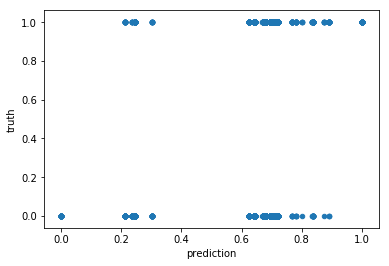

In [35]:
results.plot(kind='scatter', x='prediction', y='truth')

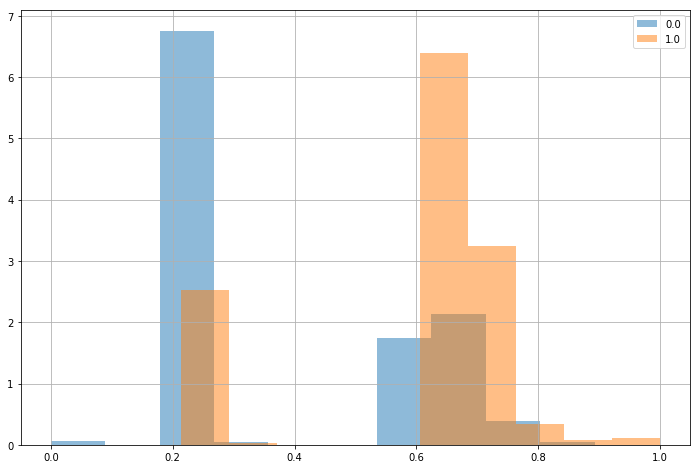

In [36]:
fig = plt.figure(figsize=(12,8))

for label, grp in tree.predict(features, leaf_map).groupby(targets):
    grp.hist(normed=True, alpha=0.5, label=str(label)) #, label=label)
plt.legend(loc='best')
None

# Compare Methods

In [214]:
features, targets = make_hastie_sample(n_samples=5000)

features_validation = features.sample(frac=.3)
targets_validation = targets.loc[features_validation.index]

features = features[~features.index.isin(features_validation.index)]
targets = targets.loc[features.index]

In [222]:
gtree.tree_logger.setLevel(logging.WARNING)

result, generations = gtree.evolve(features, targets, loss_fn=gtree.error_rate_loss, max_depth=2, min_to_split=10,
                                   num_generations=3, num_parents=5, num_children=20,
                                   alphas_per_generation=3, betas_per_generation=3)

02:47:57 evolution DEBUG:Growing Alpha: 1 of 3
02:48:07 evolution DEBUG:Growing Alpha: 2 of 3
02:48:16 evolution DEBUG:Growing Alpha: 3 of 3
02:48:26 evolution DEBUG:Growing Beta: 1 of 3
02:48:35 evolution DEBUG:Growing Beta: 2 of 3
02:48:42 evolution DEBUG:Growing Beta: 3 of 3
02:48:51 evolution DEBUG:Resplitting the data
02:48:52 evolution DEBUG:Surviving Generation: 0:0.3648, 0:0.3667, 0:0.3762, 0:0.3829, 0:0.3990
02:48:52 evolution DEBUG:Mating to create 20 children
02:48:52 evolution INFO:Generation 0 Training Loss: 0.3727 Hold Out Loss 0.3648

02:48:52 evolution DEBUG:Resplitting the data
02:48:53 evolution DEBUG:Surviving Generation: 0:0.3571, 0:0.3638, 0:0.3676, 0:0.3762, 1:0.3914
02:48:53 evolution DEBUG:Mating to create 20 children
02:48:53 evolution INFO:Generation 1 Training Loss: 0.3682 Hold Out Loss 0.3571

02:48:53 evolution DEBUG:Resplitting the data
02:48:54 evolution DEBUG:Surviving Generation: 0:0.3524, 0:0.3590, 0:0.3733, 0:0.3771, 1:0.3886
02:48:54 evolution DEBUG:

In [224]:
leaf_map = gtree.calculate_leaf_map(result['tree'], features, targets, gtree.leaf_good_rate_split_builder)

print gtree.error_rate_loss(result['tree'].predict(features_validation, leaf_map), targets_validation)

0.400666666667


In [ ]:
result = gtree.train_random_trees(features, targets, loss_fn=gtree.error_rate_loss,
                                  max_depth=2,
                                  min_to_split=10,
                                  num_trees=4)

02:49:24 evolution INFO:Num Trees: 1 Training Loss: 0.3669 Hold Out Loss 0.4038

02:49:34 evolution INFO:Num Trees: 2 Training Loss: 0.3669 Hold Out Loss 0.4038

02:49:42 evolution INFO:Num Trees: 3 Training Loss: 0.3669 Hold Out Loss 0.4038



In [ ]:
leaf_map = gtree.calculate_leaf_map(result['tree'], features, targets, gtree.leaf_good_rate_split_builder)

print gtree.error_rate_loss(result['tree'].predict(features_validation, leaf_map), targets_validation)

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(features, targets)

In [ ]:
predictions = pd.Series(clf.predict_proba(features_validation)[:, 1], index=features_validation.index)
gtree.error_rate_loss(predictions, targets_validation)